In [1]:
from FIBRSF import *

In [2]:
import pickle

In [31]:
df_dem=pd.read_parquet(path+'df_dem_frailty.parquet')#df_dem2_20210924 df_dem_20210924

In [4]:
df_pd=pd.read_parquet(path+'df_pd2_20210924.parquet')#df_pd_20210924

In [20]:
df_ad=pd.read_parquet(path+'df_ad2_20210924.parquet')#df_ad_20210924

In [6]:
df_pd.shape

(502448, 1637)

In [32]:
drops=['date_of_attending_assessment_centre_f53_0_0','AD']
wordsremove='inpatient_record|patient_polymorph|time_since_interview|_HES|records_in_hes|treatment_speciality|APOE4|Diag_PD|Age_Diag_Dementia|Age_Diag_PD|\
Parkinson|interviewer|date_of_attending_assessment_centre_f53|years_after_dis|\
Frontotemporal|daysto|hospital_recoded|from_hospital|Age_Today|year_of_birth|\
parental_ad_status_|birth_weight|parkins|\
admission_polymorphic|faster_mot|drive_faster_than|time_to_complete_round|xxxx'

config = dict(scale_pos_weight = 6,subsample = 1, min_child_weight = 5, max_depth = 5, gamma= 2, 
              colsample_bytree= 0.6,smote=1,reps=2)


from datetime import datetime # Current date time in local system 
rundate=datetime.date(datetime.now())

mod_xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, learning_rate=0.1,
           max_delta_step=0,  missing=None,
           n_estimators=60, n_jobs=4, nthread=4, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=config['scale_pos_weight'],
           min_child_weight=config['min_child_weight'],
           gamma=config['gamma'], colsample_bytree=config['colsample_bytree'],max_depth=config['max_depth'],
           seed=42, silent=None, subsample=1, verbosity=1,eval_metric='auc')

model_lr = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1,max_iter=10000)
mod_rf = RandomForestClassifier(max_depth=5, random_state=0)



In [39]:
[col for col in df_dem.columns if re.search(wordsremove,col)]

['birth_weight_known_f120_0_0',
 'drive_faster_than_motorway_speed_limit_f1100_0_0',
 'year_of_birth_f34_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_1',
 'records_in_hes_inpatient_operations_dataset_f41149_0_0',
 'intended_management_of_patient_polymorphic_f41206_0_0',
 'records_in_hes_inpatient_diagnoses_dataset_f41234_0_0',
 'destinations_on_discharge_from_hospital_recoded_f41248_0_0',
 'methods_of_admission_to_hospital_recoded_f41249_0_0',
 'sources_of_admission_to_hospital_recoded_f41251_0_0',
 'records_in_hes_inpatient_main_dataset_f41259_0_0',
 'inpatient_record_origin_f40022_0_0_HES',
 'inpatient_record_origin_f40022_0_0_PEDW',
 'inpatient_record_origin_f40022_0_0_SMR',
 'date_of_attending_assessment_centre_f53_0_0',
 'p07disorders_related_to_short_gestation_and_low_birth_weight_not_elsewhere_classified_f132326_0_0',
 'p08disorders_related_to_long_gestation_and_high_bi

In [40]:
df_dem.drop(columns=drops+['PD']+[col for col in df_dem.columns if re.search(wordsremove,col)]).\
to_parquet(path+'df_dem_ted.parquet')

In [33]:
def runmodels(df,depvar,reps,splits,drops=drops,wordsremove=wordsremove,model=mod_xgb,
             featsfit=30,LRcheck=1,resizeratio=20,agemin=60,agemax=70,verbose=0,apoe=2,tree=1,
             plot_type='dot'):
    
    mask_age=(df['age_when_attended_assessment_centre_f21003_0_0']>=agemin)&\
(df['age_when_attended_assessment_centre_f21003_0_0']<=agemax)
    df=df[mask_age]
    df=col_spec_chars(df)
    df=maskapoedf(df,apoe=apoe)
    print('%s%s%s%s' % ("Total ",depvar," ",df[depvar].sum()))
    dropvars=[col for col in df.columns if col in drops or re.search(wordsremove,col)]
    df=meanimp(df)
    outputs=runmodel(df=df,dropcols=dropvars,reps=reps,splits=splits,model=model,\
    depvar=depvar,featsfit=featsfit,LRcheck=LRcheck,resizeratio=resizeratio,verbose=verbose,tree=tree,
                    plot_type=plot_type)
    
    return outputs

def plot_ROCAUC_mult(y_test,y_score,labels,cols,figname='check'):
    
    d = dict()
    aucs=[]
    for i,x in enumerate(y_test):
        fpr, tpr, _ = roc_curve(y_test[i],y_score[i])
        mean_auc=auc(fpr, tpr)
        d["fpr{0}".format(i)] = fpr
        d["tpr{0}".format(i)] = tpr
        d["meanauc{0}".format(i)]= mean_auc
        plt.plot(fpr, tpr, cols[i], alpha = 0.8,label=r'%s (AUC = %0.2f)' % (labels[i],mean_auc))
        aucs.append(mean_auc)
        
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.xticks(fontsize='18')
    plt.yticks(fontsize='18')
    
    plt.show()
    
    plt.savefig(figname+'.svg', dpi=300)
    plt.show()
        
    return aucs

In [21]:
drops_ad=[col for col in drops if col!='AD' and col!='PD']

In [22]:
%%time
outs_ad=runmodels(df=df_ad,depvar='AD',reps=1,splits=3,drops=drops_ad,
                   wordsremove=wordsremove,model=mod_xgb,
             featsfit=30,LRcheck=0,resizeratio=20,agemin=55,agemax=70,verbose=0,apoe=2,tree=1,
             plot_type='dot')

Total AD 1400.0
0
0.005566050064749141
Val SHAP
84172
1
0.005684822059723303
Val SHAP
84171
2
0.005381869159988832
Val SHAP
84171
3
CPU times: user 4min 41s, sys: 32.8 s, total: 5min 14s
Wall time: 2min 4s


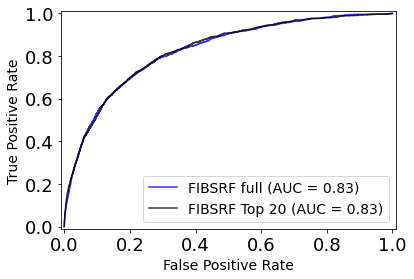

<Figure size 432x288 with 0 Axes>

[0.8255971021698739, 0.8269321304268182]

In [23]:
plot_ROCAUC_mult([outs_ad[0]['y_test'],
                 outs_ad[0]['y_test']],
                 [outs_ad[0]['risk'],
                 outs_ad[0]['risk_shap']],
                 ['FIBSRF full','FIBSRF Top 20'],
                 ['blue','black'],
                 figname='check')

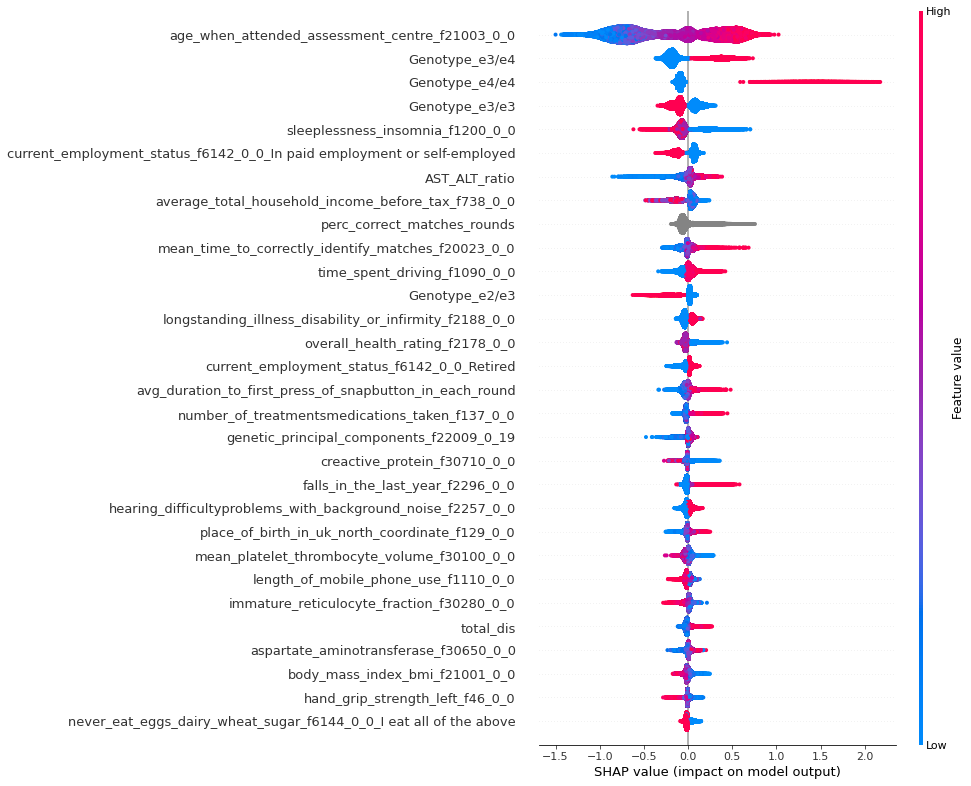

In [24]:
shap.summary_plot(outs_ad[3], outs_ad[4],
                  max_display=30,plot_type='dot')

In [13]:
outs_ad[3]

array([[-2.74093822e-04, -3.43490858e-03,  2.18966883e-03, ...,
         1.31543912e-02, -9.55099799e-03,  1.73063502e-02],
       [-7.18214549e-03, -1.47791591e-03, -3.72311473e-03, ...,
         7.64468266e-03, -6.98571699e-03, -1.74475019e-03],
       [-7.30347168e-03, -4.22794884e-03, -3.63959419e-03, ...,
        -2.69522946e-02, -2.05827598e-03,  1.23307528e-03],
       ...,
       [ 2.65166573e-02, -2.38530990e-03, -3.67688271e-03, ...,
         1.50925070e-02,  1.21128978e-03,  2.35166401e-03],
       [-6.26923749e-03, -2.88033835e-03, -2.51612789e-03, ...,
         9.04503185e-03, -8.94619152e-04,  1.13364588e-03],
       [-2.28399085e-03,  3.45060253e-05,  1.00925194e-04, ...,
         4.17227950e-03, -3.82774539e-04,  1.12213823e-03]], dtype=float32)

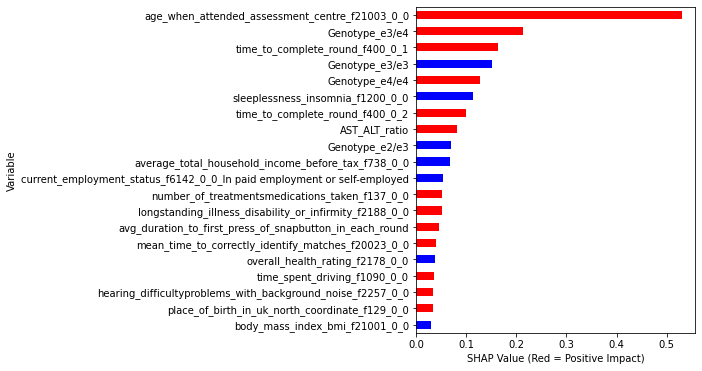

In [14]:
k2=ABS_SHAP(outs_ad[3], outs_ad[4],20)

Total dementia 2820.0
0
0.010716237515543693
Val SHAP
126257
1
SHAP for all variables


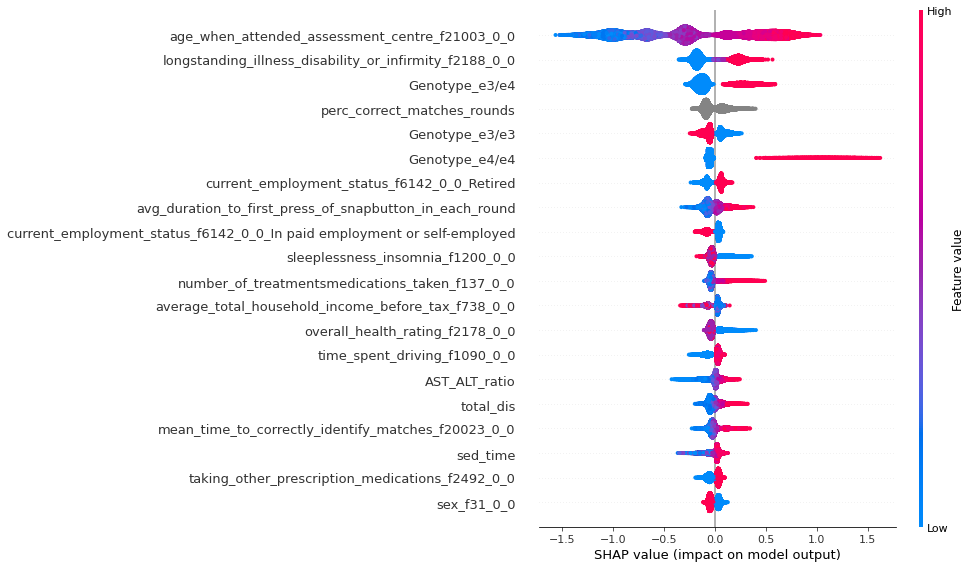

SHAP for XGBoost Selection


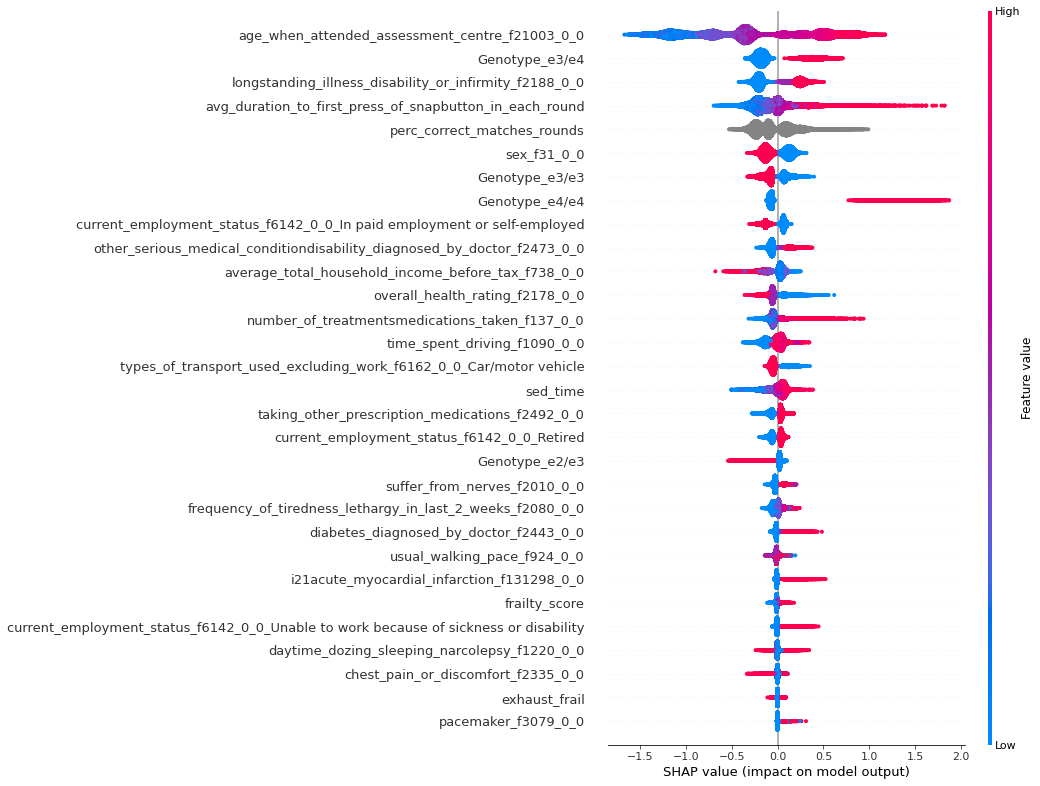

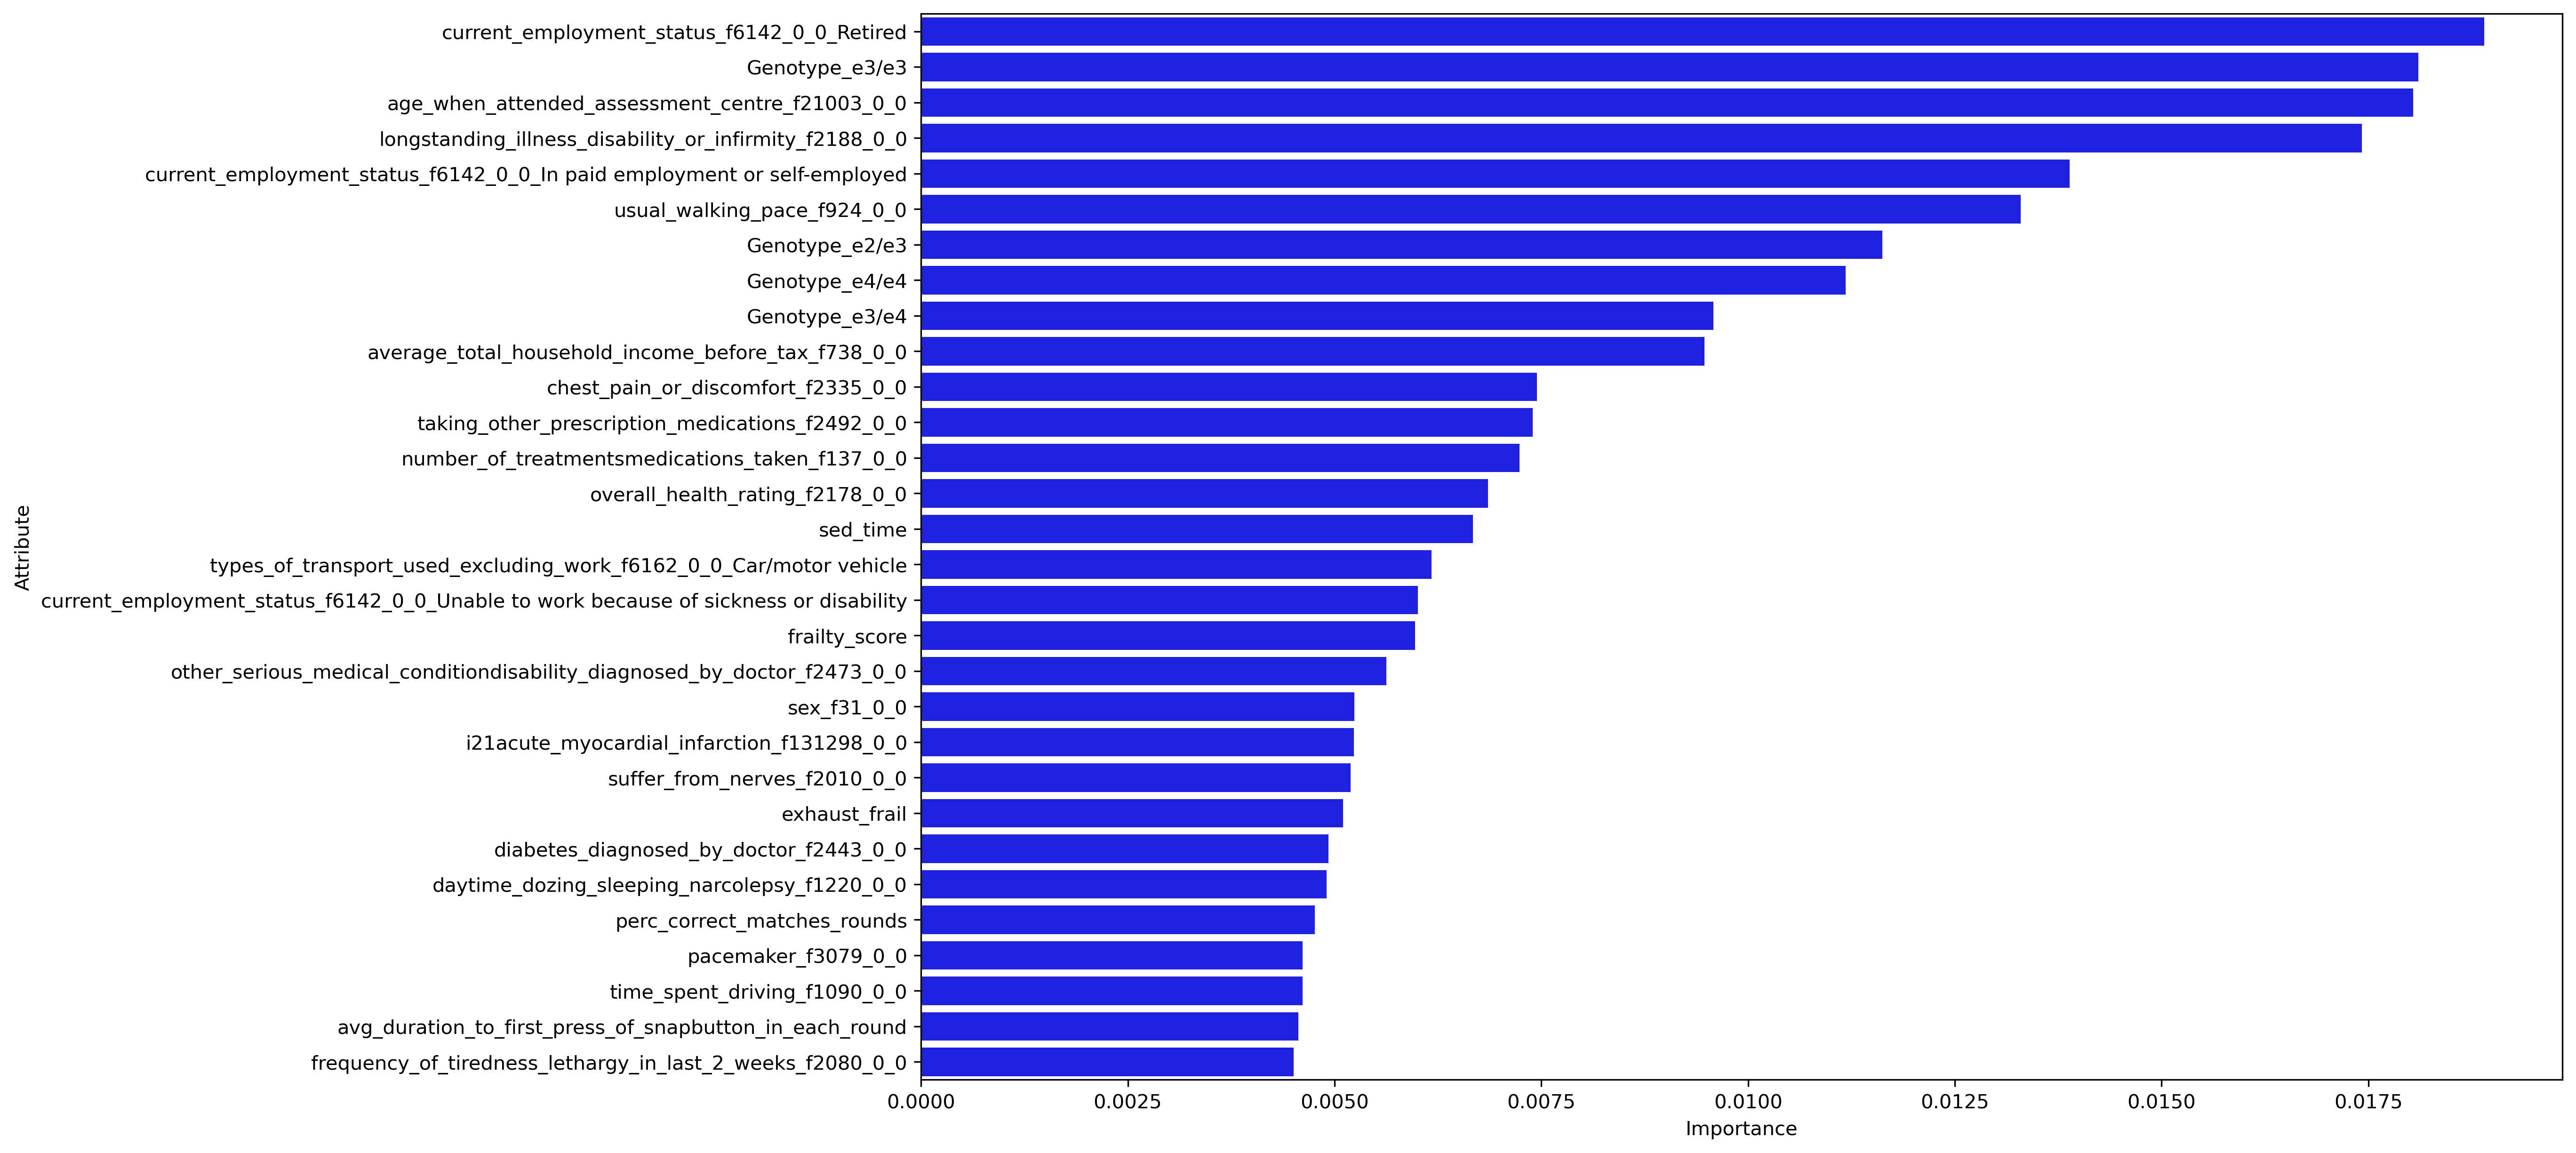

0.011619157749669325
Val SHAP
126257
2
SHAP for all variables


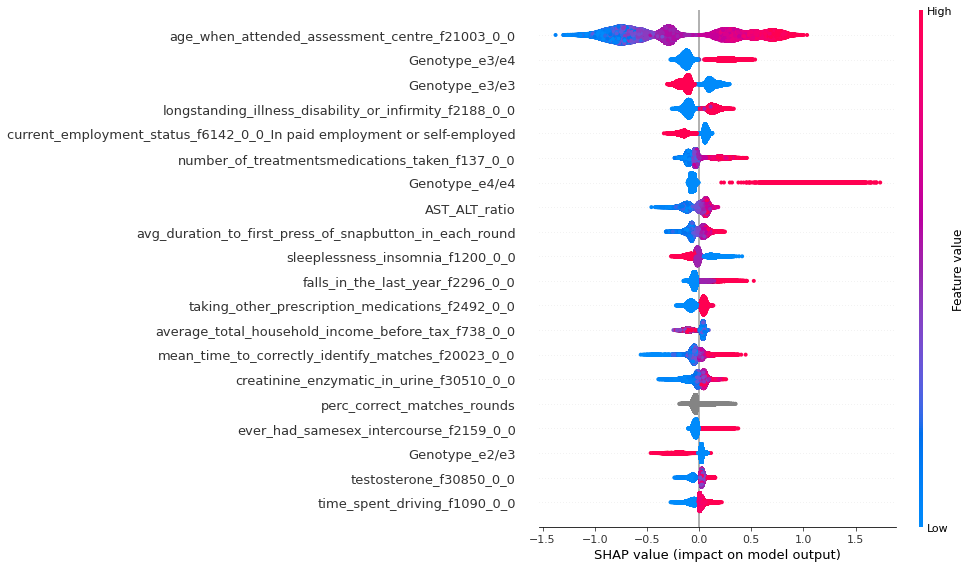

SHAP for XGBoost Selection


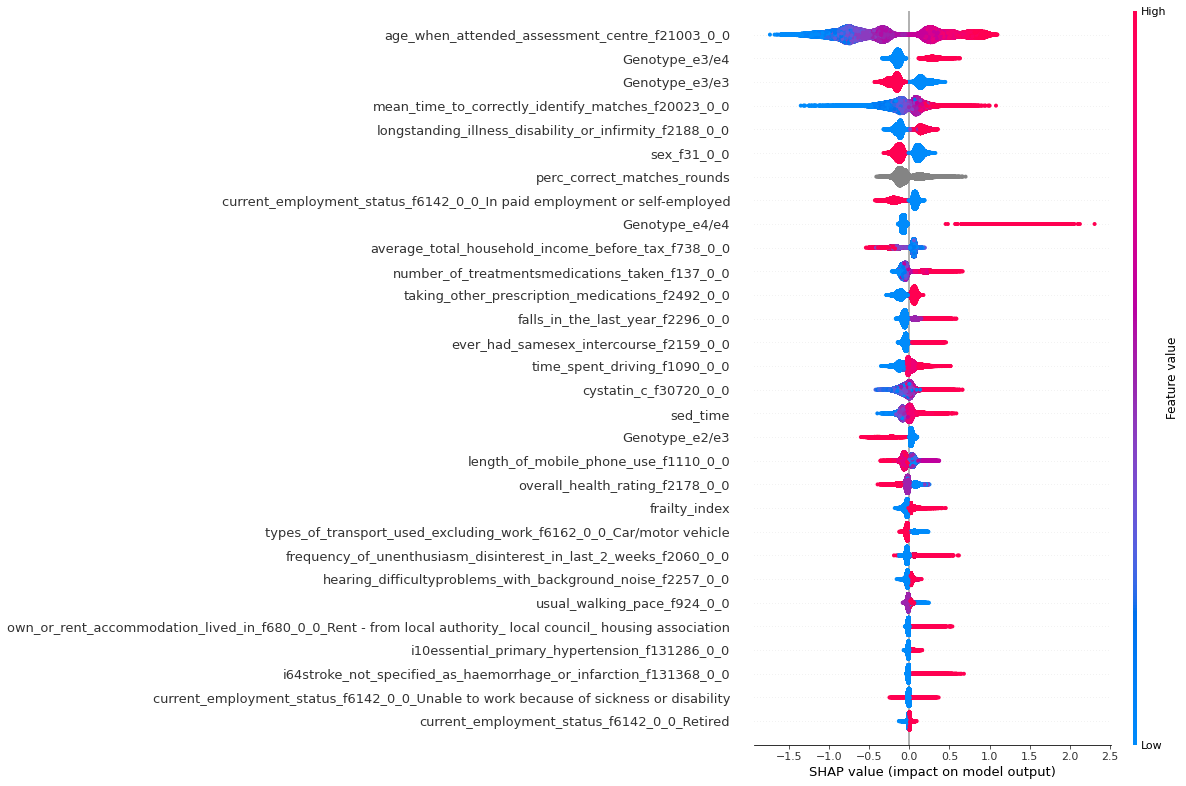

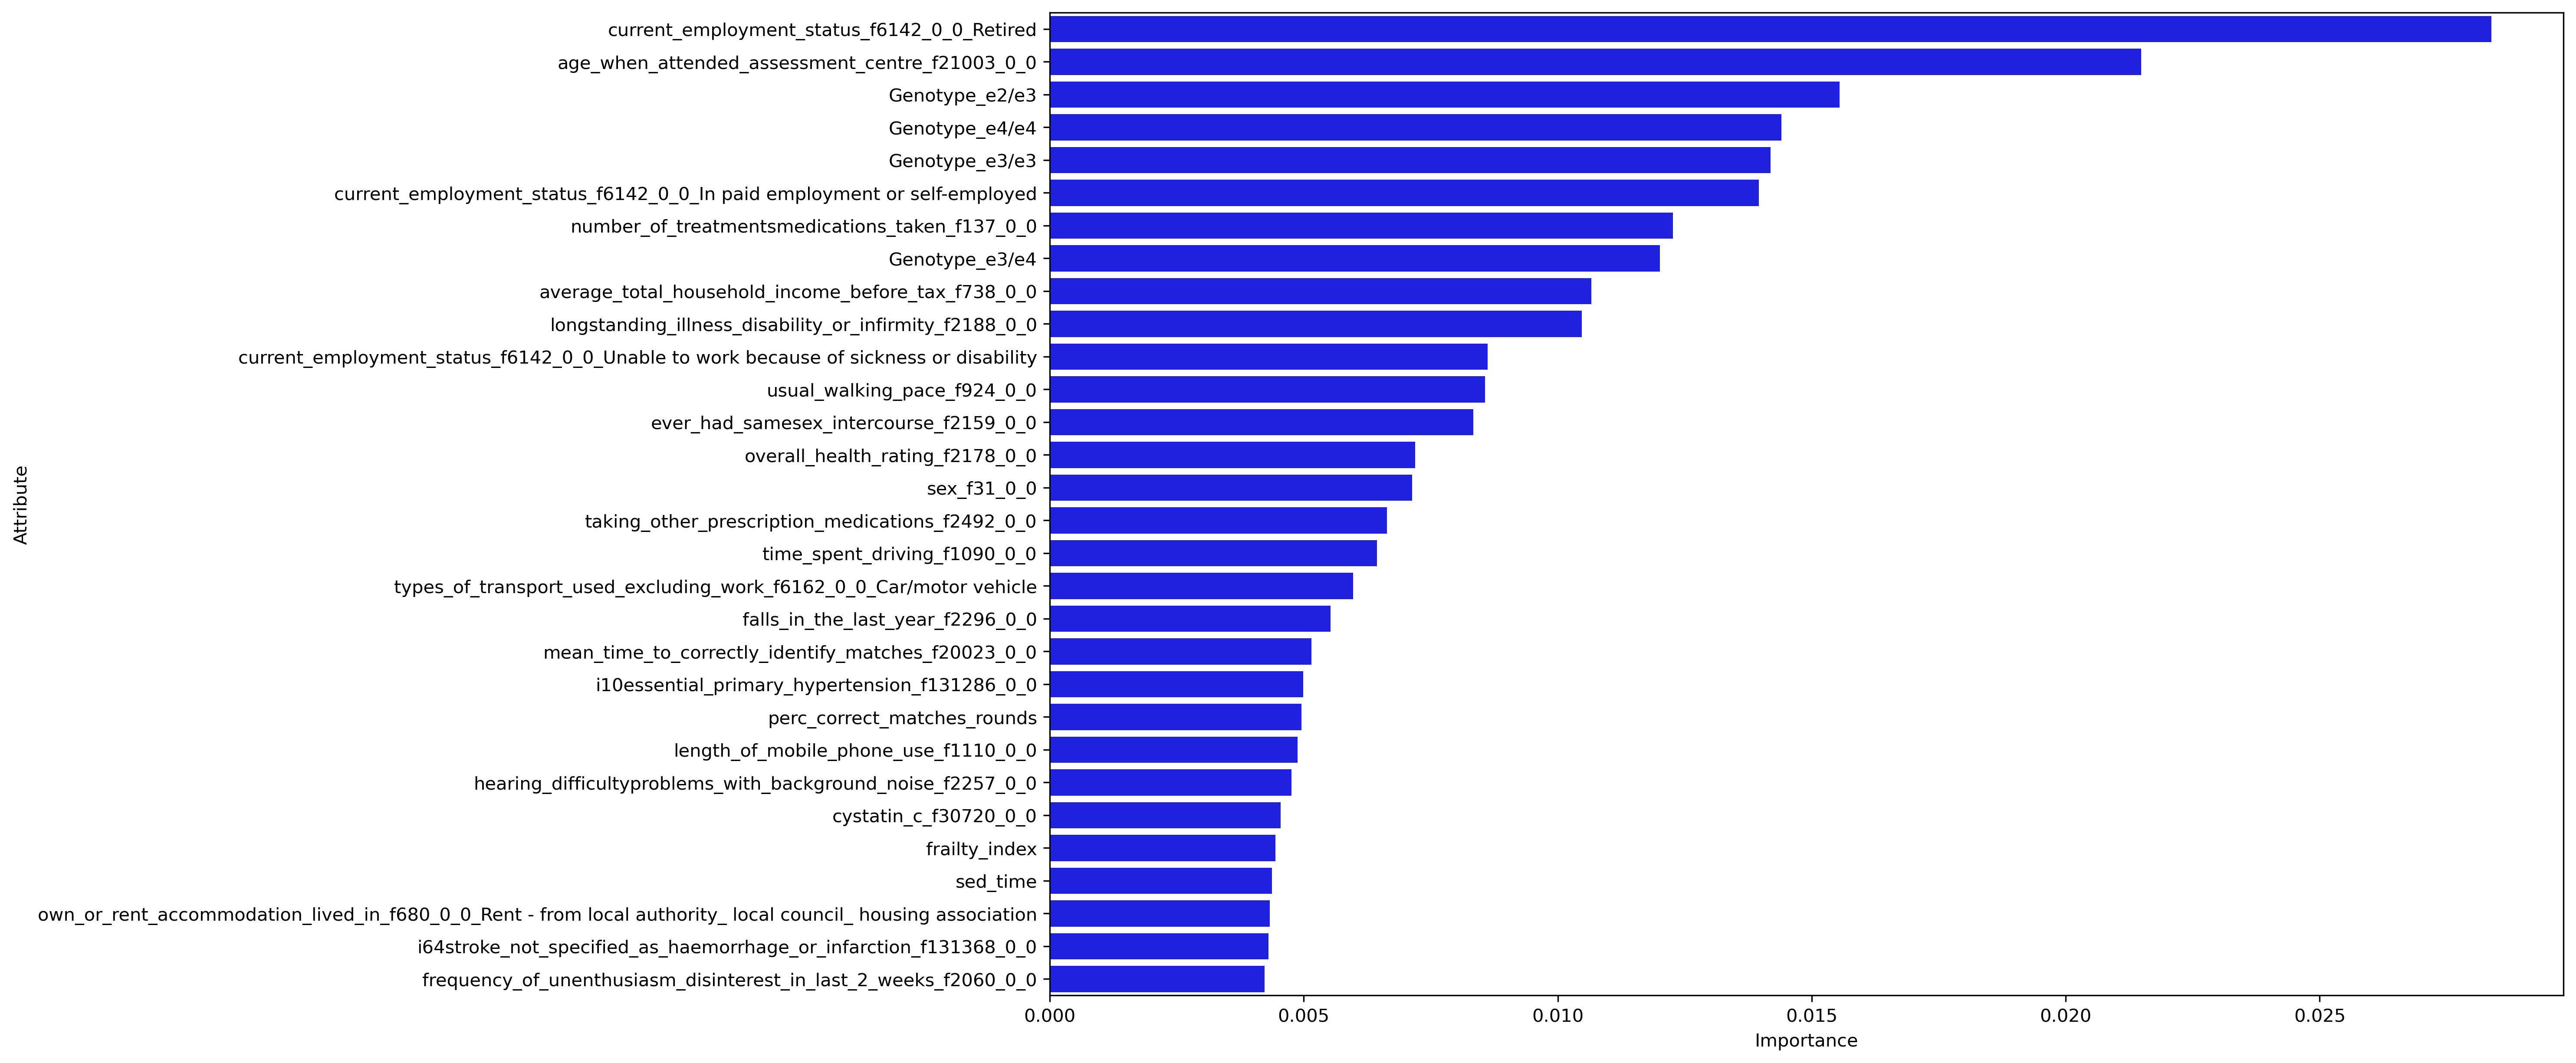

CPU times: user 7min 1s, sys: 35.7 s, total: 7min 36s
Wall time: 3min 26s


In [34]:
%%time
drops_dem=drops+['PD']
outs_dem=runmodels(df=df_dem,depvar='dementia',reps=1,splits=2,drops=drops_dem,
                   wordsremove=wordsremove,model=mod_xgb,
             featsfit=30,LRcheck=0,resizeratio=20,agemin=55,agemax=70,verbose=1,apoe=2,tree=1,
             plot_type='dot')

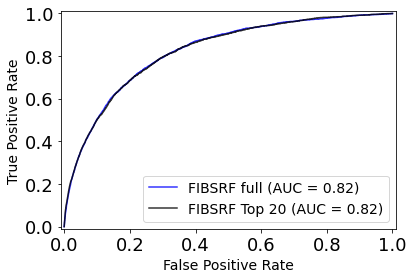

<Figure size 432x288 with 0 Axes>

[0.8228359270612479, 0.8221957562581422]

In [35]:
plot_ROCAUC_mult([outs_dem[0]['y_test'],
                 outs_dem[0]['y_test']],
                 [outs_dem[0]['risk'],
                 outs_dem[0]['risk_shap']],
                 ['FIBSRF full','FIBSRF Top 20'],
                 ['blue','black'],
                 figname='check')

In [42]:
outs_dem[1].head(40)

,column_name,shap_importance,shap_sign_importance
99,age_when_attended_assessment_centre_f21003_0_0,0.574992,-0.212325
8,Genotype_e3/e4,0.168674,-0.037389
1015,longstanding_illness_disability_or_infirmity_f...,0.158418,-0.020423
7,Genotype_e3/e3,0.109183,-0.023198
9,Genotype_e4/e4,0.083332,-0.032490
243,current_employment_status_f6142_0_0_In paid em...,0.079384,-0.017636
1405,perc_correct_matches_rounds,0.070321,-0.015394
1268,number_of_treatmentsmedications_taken_f137_0_0,0.070144,-0.017820
120,avg_duration_to_first_press_of_snapbutton_in_e...,0.069474,-0.016562
0,AST_ALT_ratio,0.062190,-0.011737


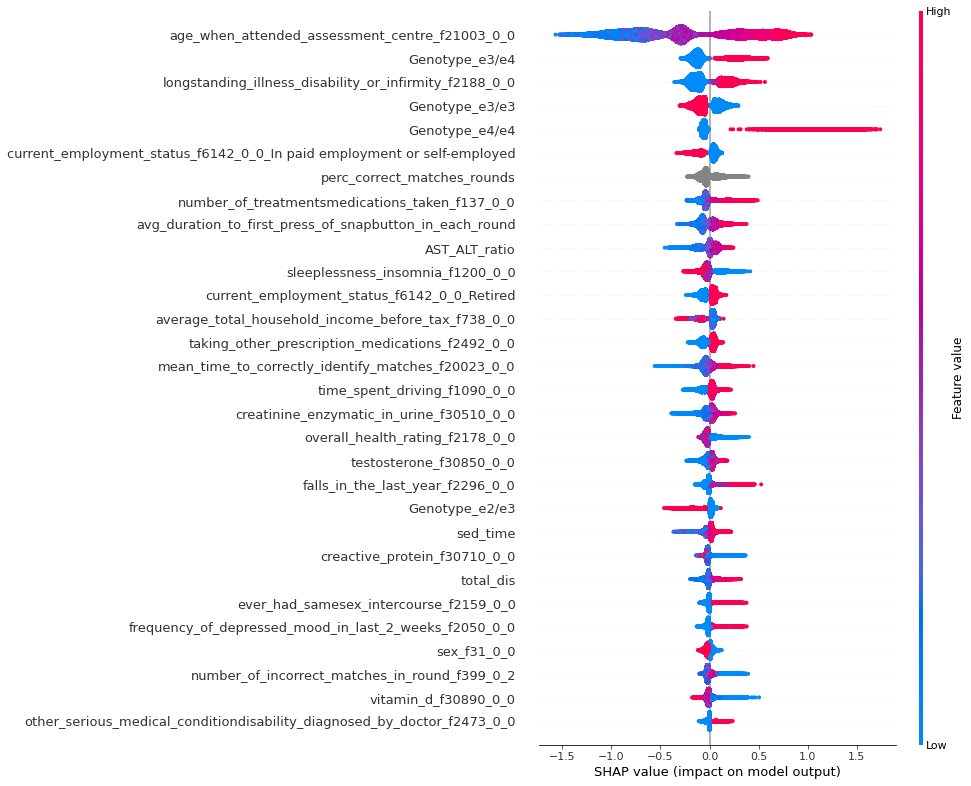

In [41]:
shap.summary_plot(outs_dem[3], outs_dem[4],
                  max_display=30,plot_type='dot')

<Figure size 3000x6000 with 0 Axes>

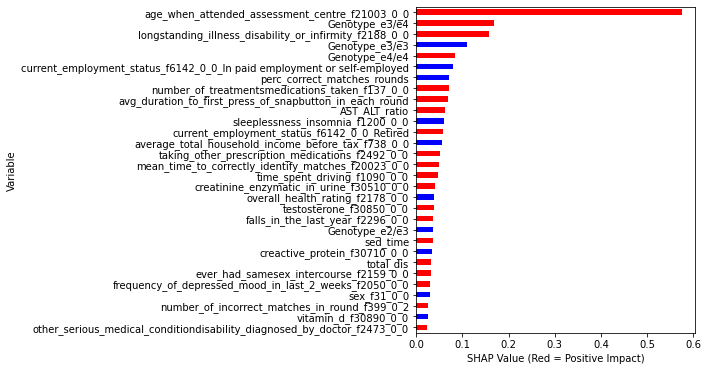

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(10, 20), dpi=300)
k2=ABS_SHAP(outs_dem[3],outs_dem[4],30)

In [18]:
%%time
dropsPD=drops+['dementia']
outs_pd=runmodels(df=df_pd,depvar='PD',reps=1,splits=2,drops=dropsPD,wordsremove=wordsremove,model=mod_xgb,
             featsfit=30,LRcheck=0,resizeratio=20,agemin=50,agemax=70,verbose=0,apoe=3,tree=1,
             plot_type='dot')

Total PD 1880.0
0
0.00464910684105151
Val SHAP
192296
1
0.005127511752714565
Val SHAP
192295
2
CPU times: user 4min 39s, sys: 50.2 s, total: 5min 29s
Wall time: 2min 39s


In [6]:
%%time
dropsPD2=drops+['dementia']
outs_pd2=runmodels(df=df_pd,depvar='PD',reps=5,splits=3,drops=dropsPD2,wordsremove=wordsremove,model=mod_xgb,
             featsfit=30,LRcheck=0,resizeratio=20,agemin=50,agemax=70,verbose=0,apoe=3,tree=1,
             plot_type='dot')

Total PD 1880.0
0
0.0046841969780884105
Val SHAP
128197
1
0.005070321458380461
Val SHAP
128197
2
0.004910411320077693
Val SHAP
128197
3
0.004929912556456079
Val SHAP
128197
4
0.004797304149083052
Val SHAP
128197
5
0.004937713051007434
Val SHAP
128197
6
0.004859708105493889
Val SHAP
128197
7
0.005039119480175043
Val SHAP
128197
8
0.004766102170877634
Val SHAP
128197
9
0.004926012309180402
Val SHAP
128197
10
0.004797304149083052
Val SHAP
128197
11
0.004941613298283111
Val SHAP
128197
12
0.0047192992035695065
Val SHAP
128197
13
0.004968915029212852
Val SHAP
128197
14
0.004976715523764207
Val SHAP
128197
15
CPU times: user 32min 28s, sys: 4min 13s, total: 36min 42s
Wall time: 15min 6s


In [9]:

outs_pd2_file=open('outs_pd2.pkl','wb')
pickle.dump(outs_pd2,outs_pd2_file)
outs_pd2_file.close()


In [3]:
outs_pd2=pd.read_pickle('outs_pd2.pkl')

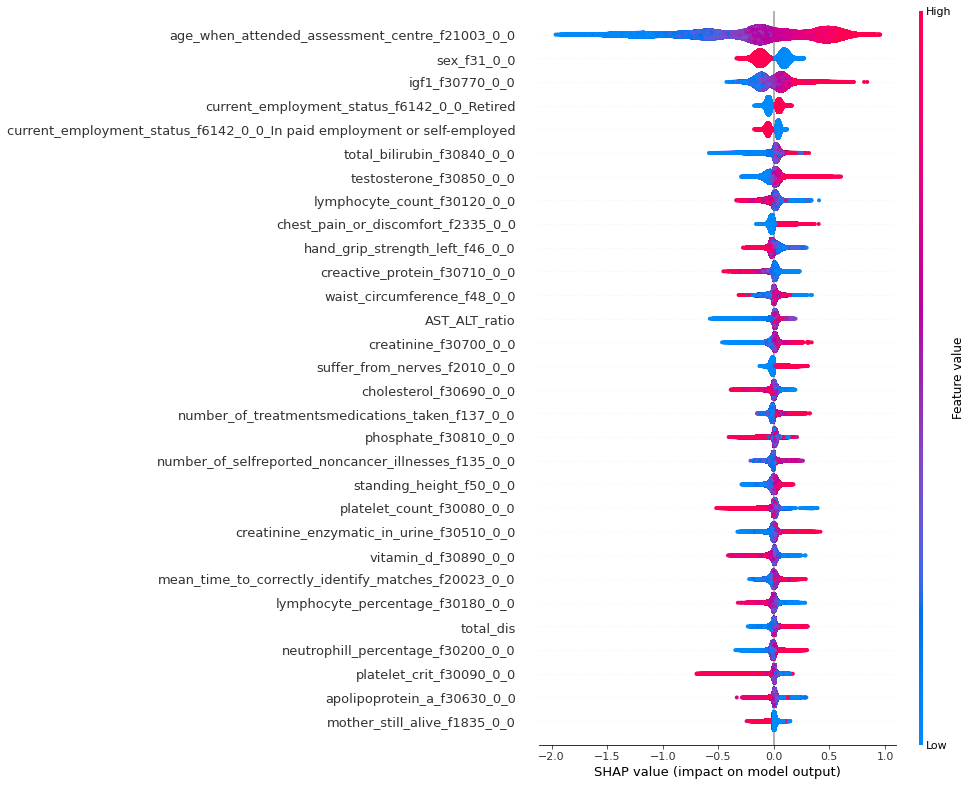

In [22]:
shap.summary_plot(shapvals, colvals,max_display=30,plot_type='dot')

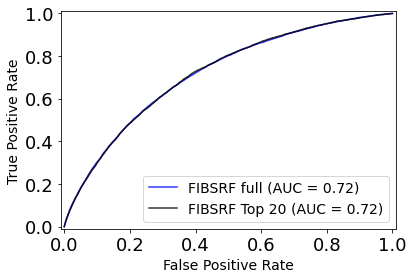

<Figure size 432x288 with 0 Axes>

[0.7176797044845293, 0.7181815937774724]

In [30]:
plot_ROCAUC_mult([outs_pd2[0]['y_test'],
                 outs_pd2[0]['y_test']],
                 [outs_pd2[0]['risk'],
                 outs_pd2[0]['risk_shap']],
                 ['FIBSRF full','FIBSRF Top 20'],
                 ['blue','black'],
                 figname='check')

In [ ]:
outs_pd2[2].head(50)

In [ ]:
shap.summary_plot(outs_pd2[3], outs_pd2[4],
                  max_display=30,plot_type='dot')

In [ ]:
shap.summary_plot(outs_pd2[3], outs_pd2[4],
                  max_display=30,plot_type='bar')

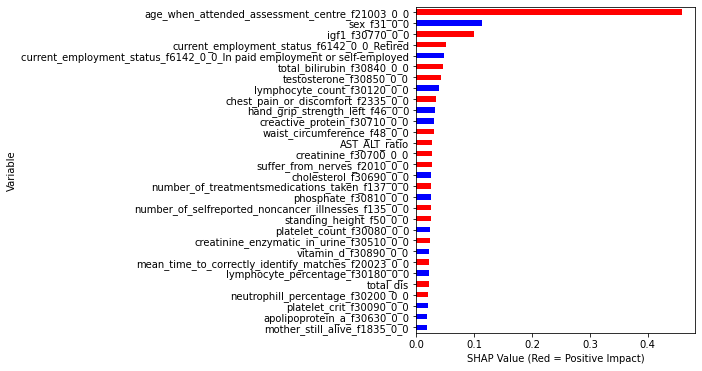

In [31]:
k2=ABS_SHAP(shapvals,colvals,30)

In [ ]:
df_pd2[(df_pd2['total_dis']<40)].groupby('total_dis')['PD'].mean().plot()

In [8]:
dis_ohe_icd10=pd.read_parquet(path+'dis_ohe_icd10.parquet')

In [10]:
def dis_list(df,depvar):
    cases=df_pd[(df_pd[depvar]==1)]
    dislist=[]
    eids=[]
    for i in range(cases.shape[0]):
        diseases=[col for col in dis_ohe_icd10.columns if cases[col].iloc[i]==1]
        dislist.append(diseases)
        eid=cases['eid'].iloc[i]
        eids.append(eid)

    check=pd.DataFrame({'eid':eids,'diseases':dislist})
    check['diseases']=check['diseases'].astype(str)

    from collections import Counter
    wordlist=''.join(check['diseases']).split()
    Counter = Counter(wordlist)
    most_occur = Counter.most_common(100)

    return most_occur,check

In [11]:
dis_list(df_pd,'PD')[1]

,eid,diseases
0,1000511,[]
1,1001664,[]
2,1001924,"['Alcohol abuse', 'Angina pectoris, unspecifie..."
3,1006845,"['Iron deficiency anemia, unspecified', 'Other..."
4,1009812,"['Anal polyp', 'Atherosclerotic heart disease ..."
...,...,...
1941,6010028,"['Cystocele', 'Diseases of the genitourinary s..."
1942,6012792,"['Essential (primary) hypertension', 'Osteoart..."
1943,6014413,[]
1944,6017598,['Derangement of other medial meniscus due to ...


In [83]:
def dis_rates(df,depvar):
    cols=[]
    pd_sums=[]
    pd_counts=[]
    for col in [col for col in dis_ohe_icd10.columns if col!='eid']:
        pd_sum=df_pd[(df_pd[col]==1)][depvar].sum()
        pd_count=df_pd[(df_pd[col]==1)][depvar].count()
        cols.append(col)
        pd_sums.append(pd_sum)
        pd_counts.append(pd_count)
    check=pd.DataFrame({'disease':cols,'total_case':pd_sums,'total_recs':pd_counts})
    check['case_rate']=check['total_case']/check['total_recs']
    
    return check



In [84]:
adrates=dis_rates(df_ad,'AD')

KeyboardInterrupt: 

In [ ]:
adrates.sort_values(by='total_case',ascending=False).head(50)

In [81]:
check.to_csv(path+'pd_dis_rates.csv')

In [79]:
check.sort_values(by='total_pd',ascending=False).head(50)

,disease,total_pd,total_recs,pd_rate
1078,Diseases of the digestive system,607.0,103538,0.005863
1088,Factors influencing health status and contact ...,545.0,107509,0.005069
1077,Diseases of the circulatory system,505.0,67863,0.007441
1094,"Symptoms, signs and abnormal clinical and labo...",488.0,85462,0.005710
1081,Diseases of the genitourinary system,363.0,76213,0.004763
287,Essential (primary) hypertension,329.0,39599,0.008308
1086,"Endocrine, nutritional and metabolic diseases",303.0,35117,0.008628
1082,Diseases of the musculoskeletal system and con...,279.0,50467,0.005528
1084,Diseases of the respiratory system,190.0,34530,0.005502
1091,Neoplasms,169.0,39580,0.004270


In [60]:

  
# most_common() produces k frequently encountered
# input values and their respective counts.


[('of', 5970), ('and', 4293), ('the', 3070), ("'Diseases", 2399), ("system',", 1737), ("unspecified',", 1221), ('health', 1093), ('with', 766), ('digestive', 735), ('not', 688), ('without', 682), ("'Other", 626), ('status', 621), ('circulatory', 619), ('abnormal', 599), ('contact', 546), ("'Factors", 545), ('influencing', 545), ('or', 530), ('other', 526), ('elsewhere', 526), ('signs', 508), ("'Symptoms,", 488), ('clinical', 488), ('laboratory', 488), ('findings,', 488), ('history', 398), ('genitourinary', 395), ('disease', 376), ('diseases', 362), ("services',", 352), ("diseases',", 344), ('unspecified', 340), ("hypertension',", 338), ('neoplasm', 337), ('(primary)', 329), ("tissue',", 312), ('specified', 311), ('nutritional', 305), ('metabolic', 305), ("'Personal", 304), ("'Endocrine,", 303), ('system', 295), ('musculoskeletal', 288), ('connective', 284), ('heart', 283), ('for', 278), ("'Essential", 259), ('respiratory', 228), ('obstruction', 224), ("gangrene',", 222), ('skin', 216),

In [62]:
[k[0] for k in most_occur]

['of',
 'and',
 'the',
 "'Diseases",
 "system',",
 "unspecified',",
 'health',
 'with',
 'digestive',
 'not',
 'without',
 "'Other",
 'status',
 'circulatory',
 'abnormal',
 'contact',
 "'Factors",
 'influencing',
 'or',
 'other',
 'elsewhere',
 'signs',
 "'Symptoms,",
 'clinical',
 'laboratory',
 'findings,',
 'history',
 'genitourinary',
 'disease',
 'diseases',
 "services',",
 "diseases',",
 'unspecified',
 "hypertension',",
 'neoplasm',
 '(primary)',
 "tissue',",
 'specified',
 'nutritional',
 'metabolic',
 "'Personal",
 "'Endocrine,",
 'system',
 'musculoskeletal',
 'connective',
 'heart',
 'for',
 "'Essential",
 'respiratory',
 'obstruction',
 "gangrene',",
 'skin',
 'to',
 'certain',
 'disorders',
 'ischemic',
 'as',
 "'Unspecified",
 'subcutaneous',
 'malignant',
 "'Pure",
 "hypercholesterolemia',",
 'lower',
 'coronary',
 'in',
 "'R074',",
 'hernia',
 'external',
 "'Injury,",
 'poisoning',
 'consequences',
 "artery',",
 'nervous',
 'diabetes',
 'eye',
 "'Type",
 'mellitus',
 "

In [42]:
check.to_csv('check.csv')

In [30]:
df_pd[dis_ohe_icd10.columns]

,eid,"Abdominal aortic aneurysm, without rupture",Abnormal cytological findings in specimens from female genital organs,Abnormal findings on diagnostic imaging of lung,Abnormal findings on diagnostic imaging of other parts of digestive tract,Abnormal results of cardiovascular function studies,Abnormal results of liver function studies,"Abnormal uterine and vaginal bleeding, unspecified",Abnormal weight loss,Abscess of Bartholin's gland,...,"Endocrine, nutritional and metabolic diseases",External causes of morbidity and mortality,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes",Mental and behavioural disorders,Neoplasms,None,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",total_dis
0,1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,1000023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,1000030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
3,1000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,1000059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502443,6025211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
502444,6025228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502445,6025235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502446,6025244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
findcols(df_pd,'walk')

['above_moderatevigorouswalking_recommendation_f22036_0_0',
 'usual_walking_pace_f924_0_0',
 'number_of_daysweek_walked_10_minutes_f864_0_0',
 'duration_of_walks_f874_0_0',
 'met_minutes_per_week_for_walking_f22037_0_0']

In [53]:
df_pd.groupby(['usual_walking_pace_f924_0_0'])['PD'].mean()

usual_walking_pace_f924_0_0
0.0    0.008940
1.0    0.004424
2.0    0.002837
Name: PD, dtype: float64